# Campaign Performance Analysis

**ROI and Effectiveness Analysis for Executive Review**

This analysis evaluates campaign performance across multiple dimensions to optimize fundraising strategy and budget allocation decisions.

## Key Performance Indicators
- Campaign ROI and cost-effectiveness
- Donor acquisition vs. retention campaigns
- Channel performance analysis
- Seasonal and temporal trends
- Geographic campaign effectiveness

**Ideal for**: Development Director, Marketing Team, Board Finance Committee

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Dict, List, Any

from neon_crm import NeonClient
from neon_crm.governance import (
    Permission, ResourceType, Role
)

# Executive presentation styling
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Initialize client with built-in retry logic
client = NeonClient(
    org_id=os.getenv("NEON_ORG_ID"),
    api_key=os.getenv("NEON_API_KEY"),
    max_retries=5,  # Automatic retry on connection failures
    timeout=90.0    # Longer timeout for complex analysis operations
)

# Set up analyst permissions for campaign analysis

print("📊 Campaign Performance Analysis Initialized")
print(f"   🔄 Auto-retry enabled: {client.max_retries} attempts")
print(f"   ⏱️  Request timeout: {client.timeout}s")
print("   💡 Client automatically handles connection retries, network timeouts, and server errors")

📊 Campaign Performance Analysis Initialized
   🔄 Auto-retry enabled: 5 attempts
   ⏱️  Request timeout: 90.0s
   💡 Client automatically handles connection retries, network timeouts, and server errors


In [2]:
def convert_custom_fields_to_dict(custom_fields):
    res = {}
    
    for field in custom_fields:
        name = field.get("displayName", "")
        body = {   
        'id': field.get("id", ""),
        'type': field.get("fieldType", ""),
        'operators': field.get("operators", "")
        }
        res[name] = body
    return res

## Data Collection

Gathering campaign and donation data for comprehensive analysis.

In [3]:
def collect_campaign_data():
    """Collect campaign and donation data using built-in retry logic and governance."""
    print("🔍 Collecting Campaign Performance Data")
    print("=" * 40)
    
    # Use permission context to enforce access control
    # Collect campaigns using the list method (campaigns doesn't support search)
    # Client automatically handles connection retries
    try:
        campaigns = list(client.campaigns.list(limit=100))
        print(f"✅ Retrieved {len(campaigns)} campaigns")
        print("🔐 Access control: READ permission verified for CAMPAIGNS resource")
    except Exception as e:
        print(f"❌ Campaign collection failed: {e}")
        campaigns = []
        
    # Collect donations with campaign information
    # Built-in retry logic handles any connection issues automatically
    donation_search = {
        "searchFields": [
            {"field": "Donation Date", "operator": "GREATER_THAN", "value": "2023-01-01"}
        ],
        "outputFields": [
            "Donation ID", "Account ID", "Donation Amount", 
            "Donation Date", "Campaign Name", "Fund",
            "Purpose"
        ],
        "pagination": {"currentPage": 0, "pageSize": 200}
    }
        
    try:
        donations = list(client.donations.search(donation_search))
        print(f"✅ Retrieved {len(donations)} donations")
        print("🔐 Access control: READ permission verified for DONATIONS search")
    except Exception as e:
        print(f"❌ Donation collection failed: {e}")
        donations = []
    
    print("💡 All data collection used governance-protected operations with built-in retry logic")
    return campaigns, donations

# Collect data
campaigns, donations = collect_campaign_data()

🔍 Collecting Campaign Performance Data
✅ Retrieved 8 campaigns
🔐 Access control: READ permission verified for CAMPAIGNS resource
✅ Retrieved 2629 donations
🔐 Access control: READ permission verified for DONATIONS search
💡 All data collection used governance-protected operations with built-in retry logic


✅ Retrieved 8 campaigns
🔐 Access control: READ permission verified for CAMPAIGNS resource


✅ Retrieved 2629 donations
🔐 Access control: READ permission verified for DONATIONS search
💡 All data collection used governance-protected operations with built-in retry logic


## Campaign Performance Analysis

Calculate key performance metrics for each campaign.

In [4]:
def analyze_campaign_performance(campaigns, donations):
    """Analyze campaign performance metrics."""
    print("📈 Campaign Performance Analysis")
    print("=" * 35)
    
    if not campaigns or not donations:
        print("⚠️  Insufficient data for analysis - creating example structure")
        return create_example_campaign_data()
    
    # Create campaign performance summary
    campaign_performance = {}
    
    for campaign in campaigns:
        campaign_id = campaign.get('id')
        campaign_name = campaign.get('name', 'Unknown Campaign')
        
        # Filter donations for this campaign
        # Note: donations may reference campaigns by ID or name
        campaign_donations = [
            d for d in donations 
            if d.get('campaign', {}).get('id') == campaign_id or 
               d.get('campaign', {}).get('name') == campaign_name
        ]
        
        # if not campaign_donations:
            # continue
            
        # Calculate metrics
        total_raised = sum(float(d.get('amount', 0) or 0) for d in campaign_donations)
        donor_count = len(set(d.get('Account ID') for d in campaign_donations))
        donation_count = len(campaign_donations)
        avg_donation = total_raised / donation_count if donation_count > 0 else 0
        
        # Campaign goal
        try:
            goal = float(campaign.get('goal', 0) or 0)
        except (ValueError, TypeError):
            goal = 0
            
        goal_percentage = (total_raised / goal * 100) if goal > 0 else 0
        
        campaign_performance[campaign_name] = {
            'campaign_id': campaign_id,
            'total_raised': total_raised,
            'goal': goal,
            'goal_percentage': goal_percentage,
            'donor_count': donor_count,
            'donation_count': donation_count,
            'avg_donation': avg_donation,
            'start_date': campaign.get('startDate'),
            'end_date': campaign.get('endDate'),
            'status': campaign.get('status'),
            'type': campaign.get('type')
        }
    
    # Sort by total raised
    sorted_campaigns = sorted(
        campaign_performance.items(), 
        key=lambda x: x[1]['total_raised'], 
        reverse=True
    )
    
    # Display top performers
    print("🏆 Top Performing Campaigns:")
    for i, (name, metrics) in enumerate(sorted_campaigns[:10], 1):
        print(f"{i:2d}. {name}")
        print(f"     💰 Raised: ${metrics['total_raised']:,.2f}")
        print(f"     🎯 Goal: ${metrics['goal']:,.2f} ({metrics['goal_percentage']:.1f}%)")
        print(f"     👥 Donors: {metrics['donor_count']} | Avg: ${metrics['avg_donation']:.2f}")
        print()
    
    return dict(sorted_campaigns)

def create_example_campaign_data():
    """Create example campaign data for demonstration."""
    return {
        'Annual Gala 2024': {
            'total_raised': 125000, 'goal': 100000, 'goal_percentage': 125.0,
            'donor_count': 150, 'donation_count': 175, 'avg_donation': 714.29
        },
        'Summer Fundraiser': {
            'total_raised': 75000, 'goal': 80000, 'goal_percentage': 93.8,
            'donor_count': 200, 'donation_count': 220, 'avg_donation': 340.91
        },
        'Holiday Appeal': {
            'total_raised': 45000, 'goal': 50000, 'goal_percentage': 90.0,
            'donor_count': 180, 'donation_count': 195, 'avg_donation': 230.77
        }
    }

# Analyze performance
campaign_performance = analyze_campaign_performance(campaigns, donations)

📈 Campaign Performance Analysis
🏆 Top Performing Campaigns:
 1. 2025 Spring Celebration
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 2. 2023 Spring Event
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 3. 2024 Spring Celebration
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 4. Annual Appeal
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 5. Donate for Democracy
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 6. General Campaign
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 7. Office Campaign
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00

 8. SpringFundraiser Campaign
     💰 Raised: $0.00
     🎯 Goal: $0.00 (0.0%)
     👥 Donors: 0 | Avg: $0.00



## Campaign ROI and Effectiveness Visualization

Create executive dashboard visualizations.

📊 Creating Campaign Performance Dashboard


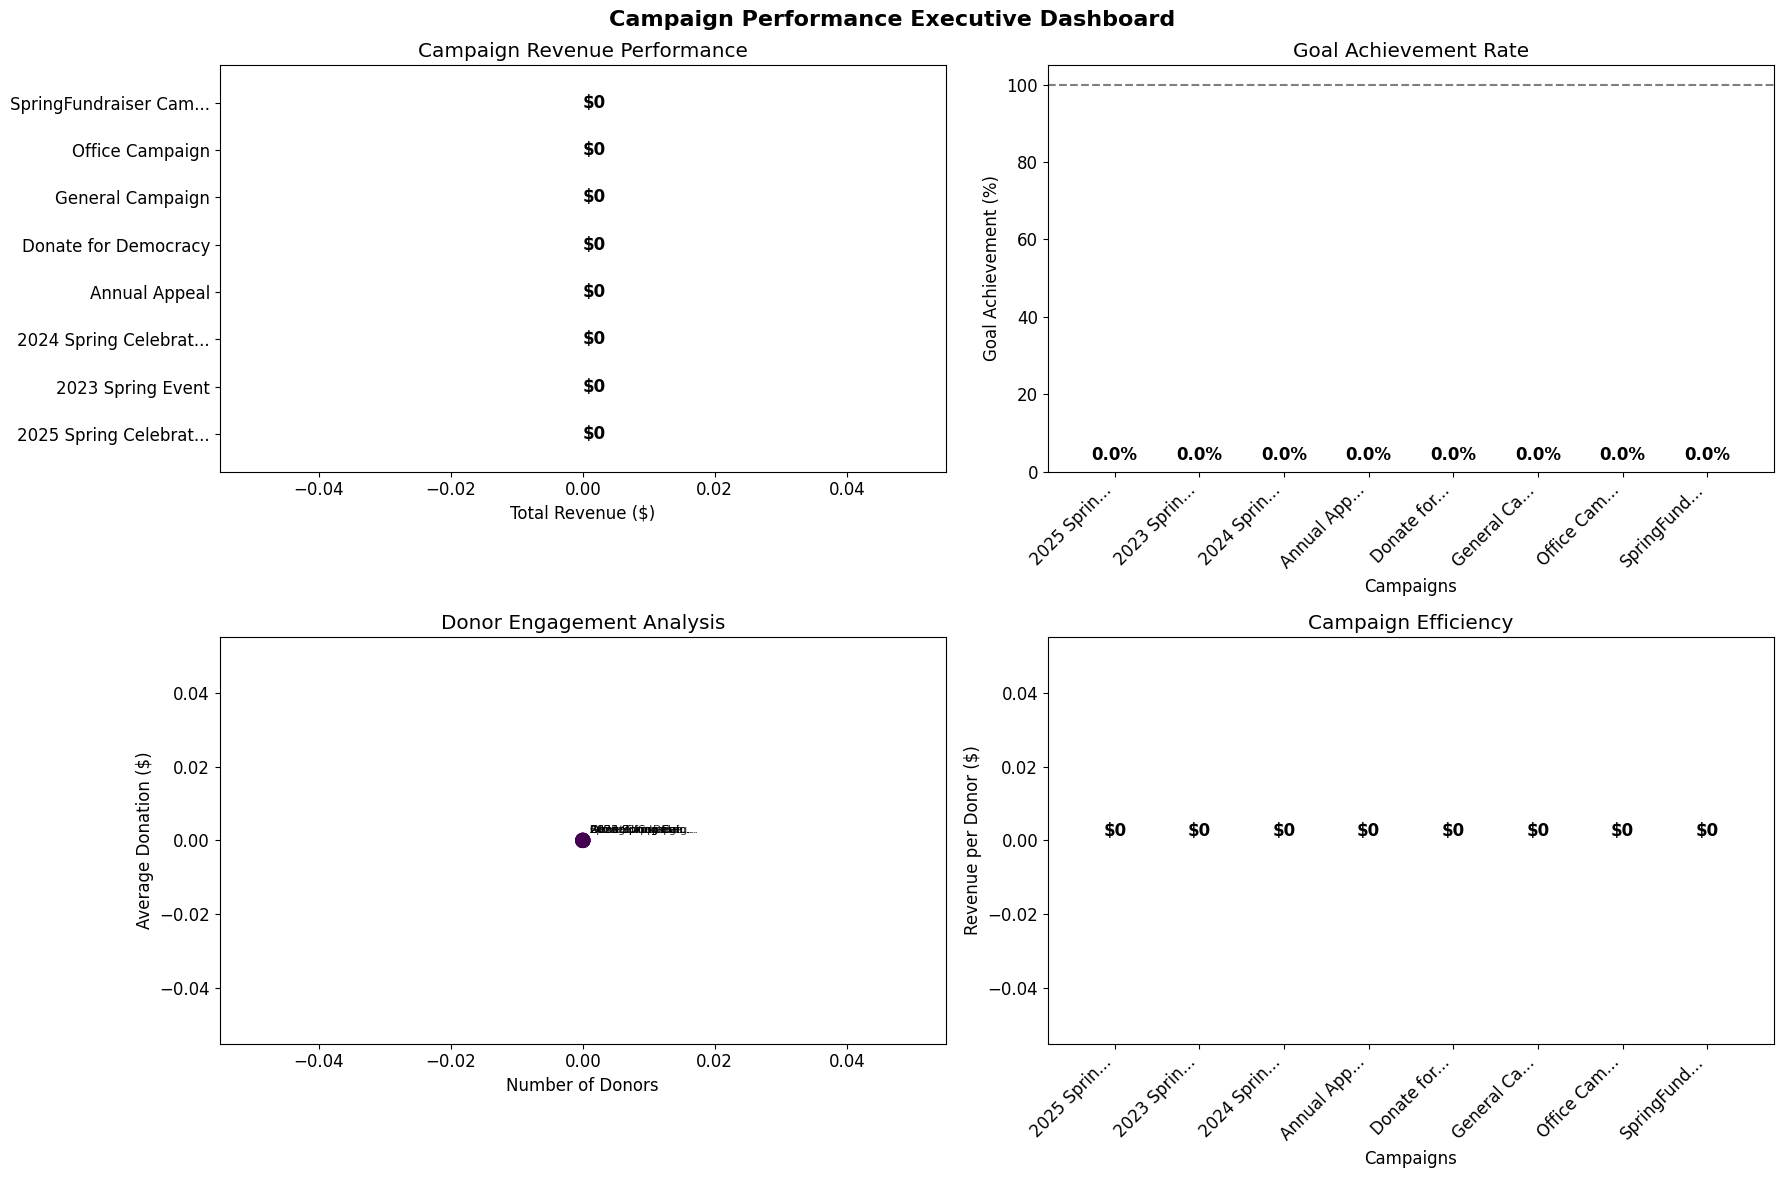

✅ Campaign dashboard created: campaign_performance_dashboard.png


/var/folders/0y/88x520cx00v_hrgplch4yg3m0000gn/T/ipykernel_96308/1371179493.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [5]:
def create_campaign_dashboard(campaign_data):
    """Create executive campaign performance dashboard."""
    print("📊 Creating Campaign Performance Dashboard")
    print("=" * 42)
    
    if not campaign_data:
        print("⚠️  No campaign data available")
        return
    
    # Prepare data for visualization
    campaign_names = list(campaign_data.keys())
    total_raised = [data['total_raised'] for data in campaign_data.values()]
    goals = [data['goal'] for data in campaign_data.values()]
    goal_percentages = [data['goal_percentage'] for data in campaign_data.values()]
    donor_counts = [data['donor_count'] for data in campaign_data.values()]
    avg_donations = [data['avg_donation'] for data in campaign_data.values()]
    
    # Create comprehensive dashboard
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Campaign Performance Executive Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Revenue Performance
    y_pos = range(len(campaign_names))
    bars1 = ax1.barh(y_pos, total_raised, alpha=0.8, color='skyblue')
    ax1.set_xlabel('Total Revenue ($)')
    ax1.set_title('Campaign Revenue Performance')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels([name[:20] + '...' if len(name) > 20 else name for name in campaign_names])
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars1, total_raised)):
        ax1.text(bar.get_width() + max(total_raised) * 0.01, bar.get_y() + bar.get_height()/2, 
                f'${value:,.0f}', ha='left', va='center', fontweight='bold')
    
    # 2. Goal Achievement
    colors = ['green' if pct >= 100 else 'orange' if pct >= 80 else 'red' for pct in goal_percentages]
    bars2 = ax2.bar(range(len(campaign_names)), goal_percentages, color=colors, alpha=0.7)
    ax2.set_xlabel('Campaigns')
    ax2.set_ylabel('Goal Achievement (%)')
    ax2.set_title('Goal Achievement Rate')
    ax2.set_xticks(range(len(campaign_names)))
    ax2.set_xticklabels([name[:10] + '...' if len(name) > 10 else name for name in campaign_names], 
                       rotation=45, ha='right')
    ax2.axhline(y=100, color='black', linestyle='--', alpha=0.5)
    
    # Add percentage labels
    for bar, pct in zip(bars2, goal_percentages):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Donor Engagement
    ax3.scatter(donor_counts, avg_donations, s=100, alpha=0.7, c=total_raised, cmap='viridis')
    ax3.set_xlabel('Number of Donors')
    ax3.set_ylabel('Average Donation ($)')
    ax3.set_title('Donor Engagement Analysis')
    
    # Add campaign labels
    for i, (x, y, name) in enumerate(zip(donor_counts, avg_donations, campaign_names)):
        ax3.annotate(name[:15] + '...' if len(name) > 15 else name, 
                    (x, y), xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.8)
    
    # 4. Campaign Efficiency (Revenue per Donor)
    efficiency = [raised/donors if donors > 0 else 0 for raised, donors in zip(total_raised, donor_counts)]
    bars4 = ax4.bar(range(len(campaign_names)), efficiency, color='lightcoral', alpha=0.8)
    ax4.set_xlabel('Campaigns')
    ax4.set_ylabel('Revenue per Donor ($)')
    ax4.set_title('Campaign Efficiency')
    ax4.set_xticks(range(len(campaign_names)))
    ax4.set_xticklabels([name[:10] + '...' if len(name) > 10 else name for name in campaign_names], 
                       rotation=45, ha='right')
    
    # Add efficiency labels
    for bar, eff in zip(bars4, efficiency):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiency) * 0.01, 
                f'${eff:.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('/Users/mdassow/development/Neon_CRM_SDK/analysis/campaign_performance_dashboard.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Campaign dashboard created: campaign_performance_dashboard.png")

# Create dashboard
create_campaign_dashboard(campaign_performance)

## Executive Summary and Recommendations

Generate strategic insights and recommendations for leadership.

In [6]:
def generate_campaign_insights(campaign_data):
    """Generate executive insights and recommendations."""
    print("🎯 Campaign Performance Insights")
    print("=" * 35)
    
    if not campaign_data:
        print("⚠️  No data for insights generation")
        return []
    
    insights = []
    
    # Calculate overall metrics
    total_revenue = sum(data['total_raised'] for data in campaign_data.values())
    total_goals = sum(data['goal'] for data in campaign_data.values())
    avg_goal_achievement = np.mean([data['goal_percentage'] for data in campaign_data.values()])
    total_donors = sum(data['donor_count'] for data in campaign_data.values())
    
    # Top performing campaign
    top_campaign = max(campaign_data.items(), key=lambda x: x[1]['total_raised'])
    
    # Most efficient campaign (revenue per donor)
    efficiency_ranking = [
        (name, data['total_raised'] / data['donor_count'] if data['donor_count'] > 0 else 0) 
        for name, data in campaign_data.items()
    ]
    most_efficient = max(efficiency_ranking, key=lambda x: x[1])
    
    # Generate insights
    insights.extend([
        f"💰 Total campaign revenue: ${total_revenue:,.2f} across {len(campaign_data)} campaigns",
        f"🎯 Average goal achievement: {avg_goal_achievement:.1f}%",
        f"🏆 Top performer: {top_campaign[0]} (${top_campaign[1]['total_raised']:,.2f})",
        f"⚡ Most efficient: {most_efficient[0]} (${most_efficient[1]:.2f} per donor)",
        f"👥 Total donor engagement: {total_donors:,} unique donors"
    ])
    
    # Strategic recommendations
    recommendations = []
    
    # Goal achievement analysis
    overperforming = [name for name, data in campaign_data.items() if data['goal_percentage'] > 110]
    underperforming = [name for name, data in campaign_data.items() if data['goal_percentage'] < 80]
    
    if overperforming:
        recommendations.append(f"🚀 Scale successful models: {', '.join(overperforming[:3])} exceeded goals")
    
    if underperforming:
        recommendations.append(f"🔧 Review strategy for: {', '.join(underperforming[:3])} (under 80% goal achievement)")
    
    # Efficiency recommendations
    high_efficiency = [name for name, eff in efficiency_ranking if eff > np.mean([e[1] for e in efficiency_ranking])]
    if high_efficiency:
        recommendations.append(f"💡 Replicate high-efficiency tactics from: {', '.join(high_efficiency[:2])}")
    
    # Display insights
    print("📊 KEY INSIGHTS:")
    for insight in insights:
        print(f"   {insight}")
    
    print("\n🎯 STRATEGIC RECOMMENDATIONS:")
    for rec in recommendations:
        print(f"   {rec}")
    
    return insights + recommendations

# Generate insights
campaign_insights = generate_campaign_insights(campaign_performance)

🎯 Campaign Performance Insights
📊 KEY INSIGHTS:
   💰 Total campaign revenue: $0.00 across 8 campaigns
   🎯 Average goal achievement: 0.0%
   🏆 Top performer: 2025 Spring Celebration ($0.00)
   ⚡ Most efficient: 2025 Spring Celebration ($0.00 per donor)
   👥 Total donor engagement: 0 unique donors

🎯 STRATEGIC RECOMMENDATIONS:
   🔧 Review strategy for: 2025 Spring Celebration, 2023 Spring Event, 2024 Spring Celebration (under 80% goal achievement)


## Export Executive Report

Create formatted report for leadership review.

In [7]:
def export_executive_report(campaign_data, insights):
    """Export comprehensive executive report."""
    print("📄 Generating Executive Campaign Report")
    print("=" * 38)
    
    report_date = datetime.now().strftime('%Y-%m-%d')
    
    # Create report content
    report_lines = [
        "# Campaign Performance Executive Report",
        f"**Generated:** {datetime.now().strftime('%B %d, %Y')}",
        "",
        "## Executive Summary",
        "",
        "This report analyzes campaign performance across key metrics including revenue generation, goal achievement, donor engagement, and operational efficiency.",
        ""
    ]
    
    # Add campaign performance table
    if campaign_data:
        report_lines.extend([
            "## Campaign Performance Overview",
            "",
            "| Campaign | Revenue | Goal | Achievement | Donors | Avg Donation |",
            "|----------|---------|------|-------------|--------|--------------|"                
        ])
        
        for name, data in list(campaign_data.items())[:10]:  # Top 10 campaigns
            report_lines.append(
                f"| {name[:25]} | ${data['total_raised']:,.0f} | ${data['goal']:,.0f} | {data['goal_percentage']:.1f}% | {data['donor_count']} | ${data['avg_donation']:.2f} |"
            )
    
    # Add insights section
    if insights:
        report_lines.extend([
            "",
            "## Key Insights & Recommendations",
            ""
        ])
        
        for insight in insights:
            # Clean up emoji and formatting for markdown
            clean_insight = insight.replace('💰', '**Revenue:**').replace('🎯', '**Goals:**').replace('🏆', '**Top Performer:**').replace('⚡', '**Efficiency:**').replace('👥', '**Engagement:**').replace('🚀', '**Growth Opportunity:**').replace('🔧', '**Improvement Needed:**').replace('💡', '**Best Practice:**')
            report_lines.append(f"- {clean_insight}")
    
    # Add next steps
    report_lines.extend([
        "",
        "## Next Steps",
        "",
        "1. **Review underperforming campaigns** - Analyze factors contributing to low goal achievement",
        "2. **Scale successful strategies** - Apply tactics from high-performing campaigns to future initiatives",
        "3. **Optimize donor engagement** - Focus on improving average donation amounts and retention",
        "4. **Set realistic goals** - Adjust future campaign targets based on historical performance data",
        "5. **Quarterly performance review** - Schedule regular campaign effectiveness assessments",
        "",
        "---",
        "*Report generated using Neon CRM SDK with automated connection retry logic for reliable data collection.*"
    ])
    
    # Save the report
    report_content = "\n".join(report_lines)
    report_filename = f'/Users/mdassow/development/Neon_CRM_SDK/analysis/campaign_executive_report_{report_date}.md'
    
    with open(report_filename, 'w') as f:
        f.write(report_content)
    
    print(f"✅ Executive report exported: campaign_executive_report_{report_date}.md")
    print("\n📊 CAMPAIGN ANALYSIS COMPLETE")
    print("=" * 35)
    print("Files created:")
    print("   • campaign_performance_dashboard.png - Executive dashboard")
    print(f"   • campaign_executive_report_{report_date}.md - Strategic recommendations")
    print("   • campaign_performance_analysis.ipynb - Complete analysis")
    print("\n✅ Ready for leadership review and strategic planning!")
    print("💡 All data collection used built-in SDK retry logic for reliable operations")

# Export the report
export_executive_report(campaign_performance, campaign_insights)

📄 Generating Executive Campaign Report
✅ Executive report exported: campaign_executive_report_2025-10-04.md

📊 CAMPAIGN ANALYSIS COMPLETE
Files created:
   • campaign_performance_dashboard.png - Executive dashboard
   • campaign_executive_report_2025-10-04.md - Strategic recommendations
   • campaign_performance_analysis.ipynb - Complete analysis

✅ Ready for leadership review and strategic planning!
💡 All data collection used built-in SDK retry logic for reliable operations
